# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

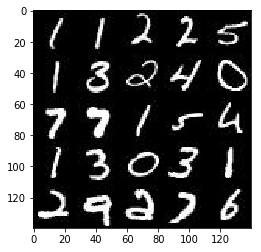

In [2]:
import numpy as np
import glob

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

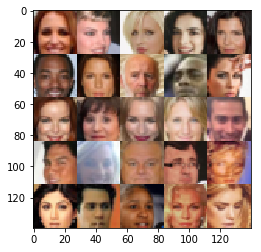

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    keep_prob = 0.9
    
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # img size 28*28*3
        x1 = tf.layers.conv2d(images, 32, 5, strides=1, padding="same")
        L_relu1 = tf.maximum(alpha*x1, x1)
        drop1 = tf.nn.dropout(L_relu1, keep_prob=keep_prob)
        
        # img size 28*28*32
        x2 = tf.layers.conv2d(drop1, 64, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        L_relu2 = tf.maximum(alpha*bn2, bn2)
        drop2 = tf.nn.dropout(L_relu2, keep_prob=keep_prob)
        
        # img size 14*14*64
        x3 = tf.layers.conv2d(drop2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        L_relu3 = tf.maximum(alpha*bn3, bn3)
        drop3 = tf.nn.dropout(L_relu3, keep_prob=keep_prob)
        
        # img size 7*7*128
        x4 = tf.layers.conv2d(drop3, 256, 5, strides=1, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=True)
        L_relu4 = tf.maximum(alpha*bn4, bn4)  
        drop4 = tf.nn.dropout(L_relu4, keep_prob=keep_prob)
        
        # img size 7*7*256
        flattened = tf.reshape(drop4, (-1, 7*7*256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    reuse = not is_train
    alpha = 0.3
    keep_prob = 0.9
    
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = reuse):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        L_relu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.nn.dropout(L_relu1, keep_prob=keep_prob)

        # img size is 7*7*512
        x2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        L_relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(L_relu2, keep_prob=keep_prob)
        
        # img size is 14*14*256
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=1, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        L_relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(L_relu3, keep_prob=keep_prob)
        
        # img size is 14*14*128
        x4 = tf.layers.conv2d_transpose(drop3, 64, 5, strides=2, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        L_relu4 = tf.maximum(alpha * bn4, bn4)
        drop4 = tf.nn.dropout(L_relu4, keep_prob=keep_prob)
        
        # img size is 28*28*64
        logits = tf.layers.conv2d_transpose(drop4, out_channel_dim, 5, strides=1, padding="same")
        # img size is 28*28*out_channel_dim
        
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim, is_train=True)
    
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True)    
    
    # discriminator loss
    real_labels = tf.ones_like(d_real_logits) * (1 - smooth)
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=real_labels, logits=d_real_logits))
    
    fake_labels = tf.zeros_like(d_fake_logits) * (1 - smooth)
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=fake_labels, logits=d_fake_logits))
    
    d_loss = real_loss + fake_loss
    
    # generator loss
    g_labels = tf.ones_like(d_fake_logits) * (1 - smooth)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=g_labels, logits=d_fake_logits)) 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    '''
    # TODO: Implement Function
    ####################################################################################
    ########### why this implementation gets errors in test function ###################
    ####################################################################################
    with tf.trainable_variables(scope="discriminator"):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss)                    
    
    with tf.trainable_variables(scope="generator"):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss)                    
    '''            
    
    
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in trainable_vars if var.name.startswith("generator")]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)                    
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    step = 0            
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # load the model
        saver.restore(sess, './model.ckpt')
        print("\n loading the model .... ")    
        
        for epoch_i in range(epoch_count):                        
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                                
                batch_images = batch_images * 2
                
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: z_batch, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={real_input: batch_images, z_input: z_batch, lr: learning_rate})
                
                train_d_loss = d_loss.eval({real_input: batch_images, z_input: z_batch})
                train_g_loss = g_loss.eval({z_input: z_batch})
                
                if(step % 10 == 0):
                    print("Epoch {}/{} ... " .format(epoch_i+1, epoch_count),
                          "Discriminator loss = {:4f}" .format(train_d_loss),
                          "Generator loss = {:4f}" .format(train_g_loss))
                                        
                    
                if(step % 100 == 0):
                    show_generator_output(sess, 25, z_input, data_shape[-1], data_image_mode)
                    # save the model
                    saver.save(sess, './model.ckpt')                      
                    
                step += 1                            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/8 ...  Discriminator loss = 2.964302 Generator loss = 0.576390


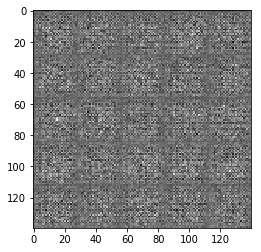

Epoch 1/8 ...  Discriminator loss = 1.433350 Generator loss = 0.874334
Epoch 1/8 ...  Discriminator loss = 1.222788 Generator loss = 1.459920


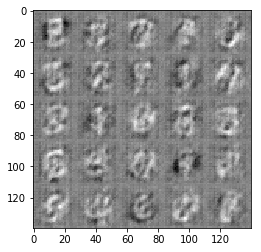

Epoch 1/8 ...  Discriminator loss = 1.017999 Generator loss = 0.953009
Epoch 1/8 ...  Discriminator loss = 1.128075 Generator loss = 1.021007


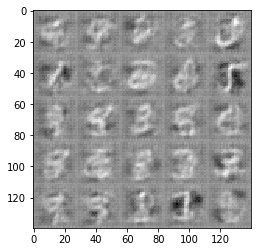

Epoch 1/8 ...  Discriminator loss = 1.434409 Generator loss = 0.631583
Epoch 1/8 ...  Discriminator loss = 1.117899 Generator loss = 1.377300


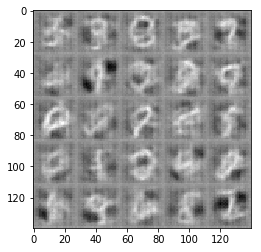

Epoch 1/8 ...  Discriminator loss = 1.004762 Generator loss = 1.265968
Epoch 1/8 ...  Discriminator loss = 0.924451 Generator loss = 1.196753


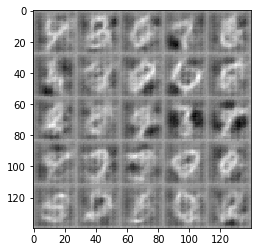

Epoch 1/8 ...  Discriminator loss = 0.940981 Generator loss = 1.305449
Epoch 2/8 ...  Discriminator loss = 1.339103 Generator loss = 0.686673


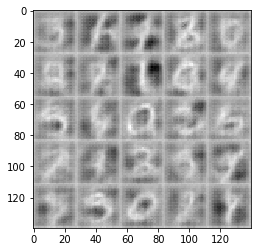

Epoch 2/8 ...  Discriminator loss = 1.190574 Generator loss = 0.800833
Epoch 2/8 ...  Discriminator loss = 0.951705 Generator loss = 1.137536


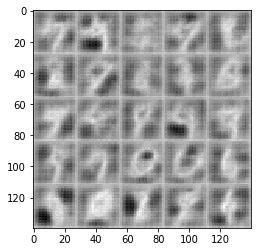

Epoch 2/8 ...  Discriminator loss = 0.818923 Generator loss = 1.336545
Epoch 2/8 ...  Discriminator loss = 0.908971 Generator loss = 1.157556


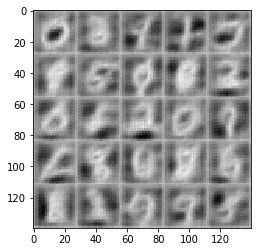

Epoch 2/8 ...  Discriminator loss = 0.890400 Generator loss = 1.232228
Epoch 2/8 ...  Discriminator loss = 0.914743 Generator loss = 1.533412


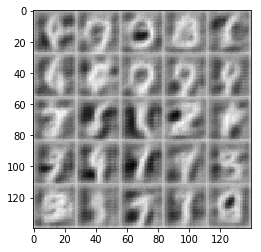

Epoch 2/8 ...  Discriminator loss = 1.198340 Generator loss = 0.804991
Epoch 2/8 ...  Discriminator loss = 1.002280 Generator loss = 0.979128


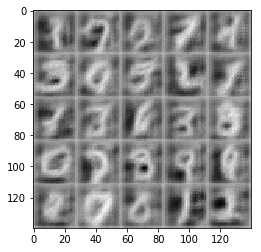

Epoch 3/8 ...  Discriminator loss = 0.914997 Generator loss = 1.184768
Epoch 3/8 ...  Discriminator loss = 0.941039 Generator loss = 1.066865


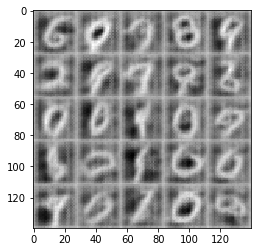

Epoch 3/8 ...  Discriminator loss = 0.828347 Generator loss = 1.357403
Epoch 3/8 ...  Discriminator loss = 1.193797 Generator loss = 0.800554


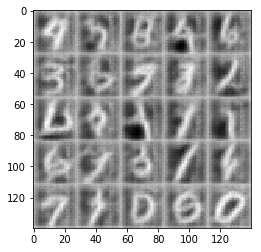

Epoch 3/8 ...  Discriminator loss = 1.094962 Generator loss = 2.348514
Epoch 3/8 ...  Discriminator loss = 1.653222 Generator loss = 0.717582


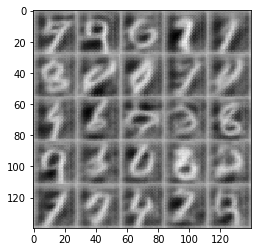

Epoch 3/8 ...  Discriminator loss = 0.943775 Generator loss = 1.032491
Epoch 3/8 ...  Discriminator loss = 1.649762 Generator loss = 0.737630


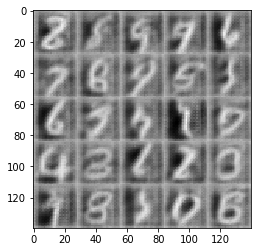

Epoch 3/8 ...  Discriminator loss = 0.932900 Generator loss = 1.400872
Epoch 3/8 ...  Discriminator loss = 1.258024 Generator loss = 0.879549


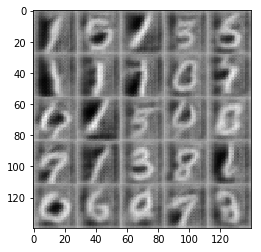

Epoch 4/8 ...  Discriminator loss = 0.883371 Generator loss = 1.166359
Epoch 4/8 ...  Discriminator loss = 1.145267 Generator loss = 0.853961


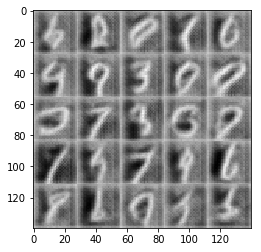

Epoch 4/8 ...  Discriminator loss = 0.872923 Generator loss = 1.221807
Epoch 4/8 ...  Discriminator loss = 0.804940 Generator loss = 1.330893


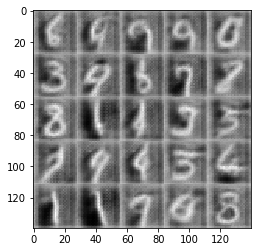

Epoch 4/8 ...  Discriminator loss = 0.930950 Generator loss = 1.070008
Epoch 4/8 ...  Discriminator loss = 0.815594 Generator loss = 1.294927


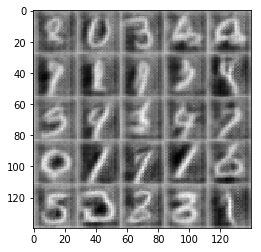

Epoch 4/8 ...  Discriminator loss = 0.620880 Generator loss = 2.134531
Epoch 4/8 ...  Discriminator loss = 0.785941 Generator loss = 1.329042


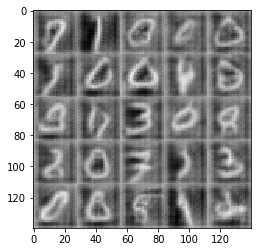

Epoch 4/8 ...  Discriminator loss = 0.864903 Generator loss = 1.545254
Epoch 5/8 ...  Discriminator loss = 0.843825 Generator loss = 2.215136


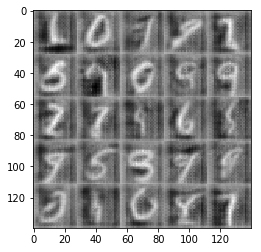

Epoch 5/8 ...  Discriminator loss = 0.740161 Generator loss = 1.576575
Epoch 5/8 ...  Discriminator loss = 0.879987 Generator loss = 1.188942


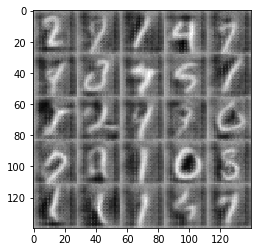

Epoch 5/8 ...  Discriminator loss = 0.880103 Generator loss = 1.724143
Epoch 5/8 ...  Discriminator loss = 0.802912 Generator loss = 1.508013


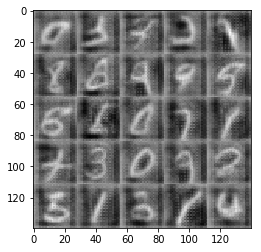

Epoch 5/8 ...  Discriminator loss = 0.800051 Generator loss = 1.353315
Epoch 5/8 ...  Discriminator loss = 0.698732 Generator loss = 1.840393


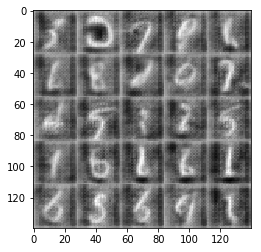

Epoch 5/8 ...  Discriminator loss = 0.785917 Generator loss = 1.566780
Epoch 5/8 ...  Discriminator loss = 0.798307 Generator loss = 1.338867


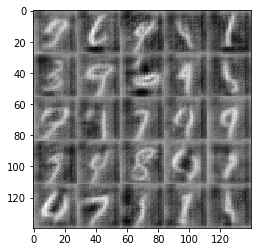

Epoch 6/8 ...  Discriminator loss = 0.752172 Generator loss = 1.900805
Epoch 6/8 ...  Discriminator loss = 1.094226 Generator loss = 0.881029


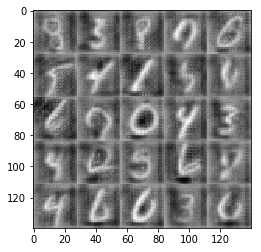

Epoch 6/8 ...  Discriminator loss = 0.882645 Generator loss = 1.454823
Epoch 6/8 ...  Discriminator loss = 0.862864 Generator loss = 1.284901


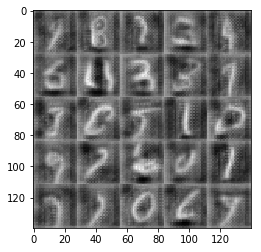

Epoch 6/8 ...  Discriminator loss = 0.879335 Generator loss = 1.211848
Epoch 6/8 ...  Discriminator loss = 0.806643 Generator loss = 1.375226


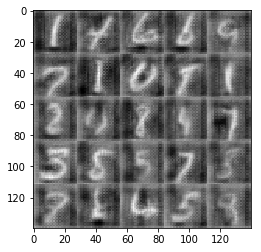

Epoch 6/8 ...  Discriminator loss = 1.055068 Generator loss = 2.121463
Epoch 6/8 ...  Discriminator loss = 0.948106 Generator loss = 1.052883


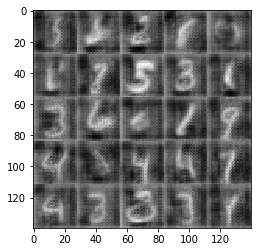

Epoch 6/8 ...  Discriminator loss = 0.676365 Generator loss = 2.017957
Epoch 6/8 ...  Discriminator loss = 0.864139 Generator loss = 1.206039


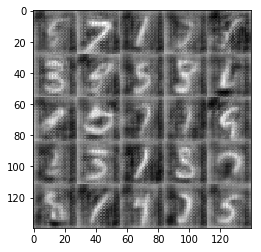

Epoch 7/8 ...  Discriminator loss = 0.864044 Generator loss = 1.434343
Epoch 7/8 ...  Discriminator loss = 1.043844 Generator loss = 0.978688


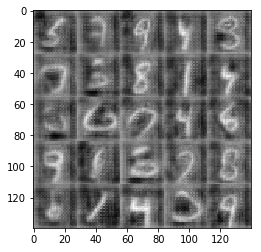

Epoch 7/8 ...  Discriminator loss = 0.819051 Generator loss = 1.896144
Epoch 7/8 ...  Discriminator loss = 1.005436 Generator loss = 1.019446


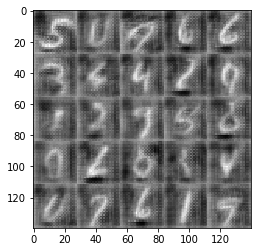

Epoch 7/8 ...  Discriminator loss = 0.968201 Generator loss = 1.069131
Epoch 7/8 ...  Discriminator loss = 0.861884 Generator loss = 1.229581


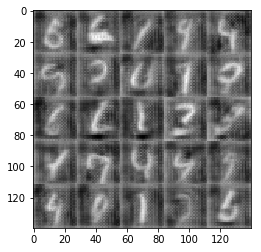

Epoch 7/8 ...  Discriminator loss = 2.843018 Generator loss = 5.082327
Epoch 7/8 ...  Discriminator loss = 0.965600 Generator loss = 1.009901


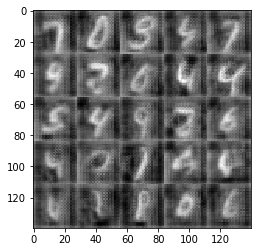

Epoch 7/8 ...  Discriminator loss = 1.300176 Generator loss = 0.764024
Epoch 8/8 ...  Discriminator loss = 0.791116 Generator loss = 1.651459


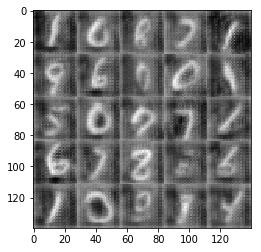

Epoch 8/8 ...  Discriminator loss = 0.748082 Generator loss = 2.020232
Epoch 8/8 ...  Discriminator loss = 0.990122 Generator loss = 0.982965


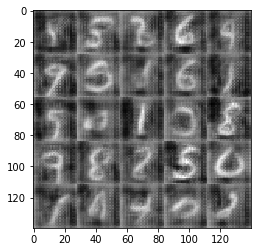

Epoch 8/8 ...  Discriminator loss = 0.657033 Generator loss = 1.865130
Epoch 8/8 ...  Discriminator loss = 1.395806 Generator loss = 0.696561


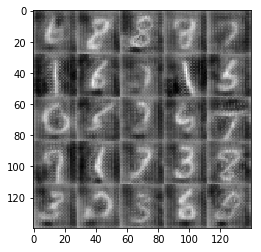

Epoch 8/8 ...  Discriminator loss = 0.767476 Generator loss = 1.537250
Epoch 8/8 ...  Discriminator loss = 0.895608 Generator loss = 1.371088


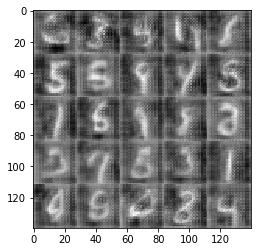

Epoch 8/8 ...  Discriminator loss = 0.950702 Generator loss = 1.543467
Epoch 8/8 ...  Discriminator loss = 0.761687 Generator loss = 1.723496


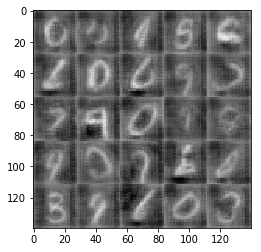

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 8

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

INFO:tensorflow:Restoring parameters from ./model.ckpt

 loading the model .... 
Epoch 1/1 ...  Discriminator loss = 0.392062 Generator loss = 3.181565


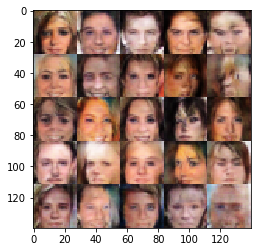

Epoch 1/1 ...  Discriminator loss = 0.384754 Generator loss = 3.954142
Epoch 1/1 ...  Discriminator loss = 0.410043 Generator loss = 3.642509
Epoch 1/1 ...  Discriminator loss = 0.386854 Generator loss = 3.291135
Epoch 1/1 ...  Discriminator loss = 0.444504 Generator loss = 3.776290
Epoch 1/1 ...  Discriminator loss = 0.674198 Generator loss = 4.002789
Epoch 1/1 ...  Discriminator loss = 0.391758 Generator loss = 4.367375
Epoch 1/1 ...  Discriminator loss = 0.470509 Generator loss = 3.583261
Epoch 1/1 ...  Discriminator loss = 0.414797 Generator loss = 4.591039
Epoch 1/1 ...  Discriminator loss = 0.477929 Generator loss = 2.834566
Epoch 1/1 ...  Discriminator loss = 0.395008 Generator loss = 3.972439


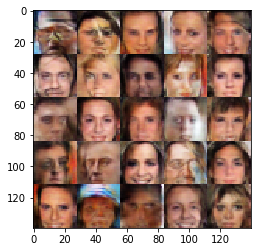

Epoch 1/1 ...  Discriminator loss = 0.443881 Generator loss = 3.892687
Epoch 1/1 ...  Discriminator loss = 0.401077 Generator loss = 4.402480
Epoch 1/1 ...  Discriminator loss = 0.393058 Generator loss = 4.285942
Epoch 1/1 ...  Discriminator loss = 0.377044 Generator loss = 3.369862
Epoch 1/1 ...  Discriminator loss = 0.396321 Generator loss = 4.337262
Epoch 1/1 ...  Discriminator loss = 0.377537 Generator loss = 3.737755
Epoch 1/1 ...  Discriminator loss = 0.472372 Generator loss = 3.201615
Epoch 1/1 ...  Discriminator loss = 0.395092 Generator loss = 3.379274
Epoch 1/1 ...  Discriminator loss = 0.400608 Generator loss = 3.896940
Epoch 1/1 ...  Discriminator loss = 0.456823 Generator loss = 3.344162


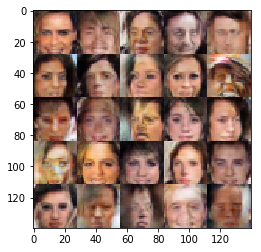

Epoch 1/1 ...  Discriminator loss = 0.390215 Generator loss = 4.388355
Epoch 1/1 ...  Discriminator loss = 0.395614 Generator loss = 2.460355
Epoch 1/1 ...  Discriminator loss = 0.370354 Generator loss = 5.088085
Epoch 1/1 ...  Discriminator loss = 0.439894 Generator loss = 4.331246
Epoch 1/1 ...  Discriminator loss = 0.414591 Generator loss = 3.482693
Epoch 1/1 ...  Discriminator loss = 0.529606 Generator loss = 2.481589
Epoch 1/1 ...  Discriminator loss = 0.379512 Generator loss = 4.763530
Epoch 1/1 ...  Discriminator loss = 0.535200 Generator loss = 2.699483
Epoch 1/1 ...  Discriminator loss = 0.357267 Generator loss = 3.893059
Epoch 1/1 ...  Discriminator loss = 0.367320 Generator loss = 3.459766


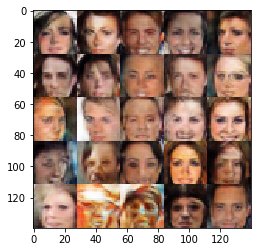

Epoch 1/1 ...  Discriminator loss = 0.393293 Generator loss = 3.831017
Epoch 1/1 ...  Discriminator loss = 0.400021 Generator loss = 2.952651
Epoch 1/1 ...  Discriminator loss = 0.388895 Generator loss = 4.125259
Epoch 1/1 ...  Discriminator loss = 0.465494 Generator loss = 5.524519
Epoch 1/1 ...  Discriminator loss = 0.497346 Generator loss = 4.306465
Epoch 1/1 ...  Discriminator loss = 0.413688 Generator loss = 4.090709
Epoch 1/1 ...  Discriminator loss = 0.374524 Generator loss = 3.142446
Epoch 1/1 ...  Discriminator loss = 0.388805 Generator loss = 4.313449
Epoch 1/1 ...  Discriminator loss = 0.483224 Generator loss = 4.355499
Epoch 1/1 ...  Discriminator loss = 0.373742 Generator loss = 3.731868


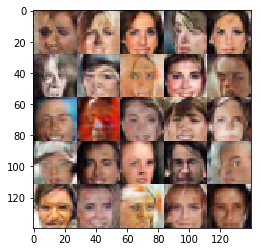

Epoch 1/1 ...  Discriminator loss = 0.408770 Generator loss = 4.495097
Epoch 1/1 ...  Discriminator loss = 0.376139 Generator loss = 3.137154
Epoch 1/1 ...  Discriminator loss = 0.506390 Generator loss = 3.673603
Epoch 1/1 ...  Discriminator loss = 0.396675 Generator loss = 4.234841
Epoch 1/1 ...  Discriminator loss = 0.418842 Generator loss = 3.932883
Epoch 1/1 ...  Discriminator loss = 0.378320 Generator loss = 3.232910
Epoch 1/1 ...  Discriminator loss = 0.544614 Generator loss = 3.540439
Epoch 1/1 ...  Discriminator loss = 0.380550 Generator loss = 5.390850
Epoch 1/1 ...  Discriminator loss = 0.496282 Generator loss = 2.118631
Epoch 1/1 ...  Discriminator loss = 0.357577 Generator loss = 2.894536


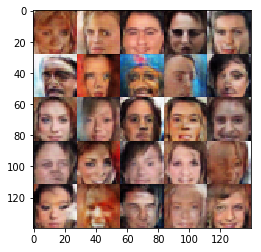

Epoch 1/1 ...  Discriminator loss = 0.474726 Generator loss = 5.061711
Epoch 1/1 ...  Discriminator loss = 0.399319 Generator loss = 3.791342
Epoch 1/1 ...  Discriminator loss = 0.378753 Generator loss = 3.505848
Epoch 1/1 ...  Discriminator loss = 0.503104 Generator loss = 2.937798
Epoch 1/1 ...  Discriminator loss = 0.391761 Generator loss = 3.125690
Epoch 1/1 ...  Discriminator loss = 0.423161 Generator loss = 2.429062
Epoch 1/1 ...  Discriminator loss = 0.396819 Generator loss = 5.168957
Epoch 1/1 ...  Discriminator loss = 0.372257 Generator loss = 4.131125
Epoch 1/1 ...  Discriminator loss = 0.354043 Generator loss = 4.214931
Epoch 1/1 ...  Discriminator loss = 0.392167 Generator loss = 3.499560


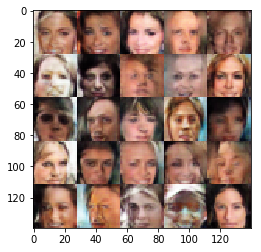

Epoch 1/1 ...  Discriminator loss = 0.691693 Generator loss = 3.298679
Epoch 1/1 ...  Discriminator loss = 0.396777 Generator loss = 2.704302
Epoch 1/1 ...  Discriminator loss = 0.526219 Generator loss = 3.318696
Epoch 1/1 ...  Discriminator loss = 0.542828 Generator loss = 4.334500
Epoch 1/1 ...  Discriminator loss = 0.581698 Generator loss = 1.558457
Epoch 1/1 ...  Discriminator loss = 0.471166 Generator loss = 3.991931
Epoch 1/1 ...  Discriminator loss = 0.414064 Generator loss = 5.157744
Epoch 1/1 ...  Discriminator loss = 0.357569 Generator loss = 3.996422
Epoch 1/1 ...  Discriminator loss = 0.372573 Generator loss = 4.129561
Epoch 1/1 ...  Discriminator loss = 0.384784 Generator loss = 5.491050


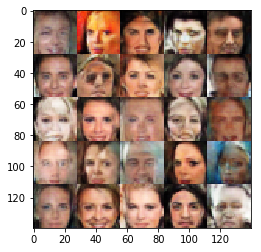

Epoch 1/1 ...  Discriminator loss = 0.787704 Generator loss = 2.833036
Epoch 1/1 ...  Discriminator loss = 0.456784 Generator loss = 3.675682
Epoch 1/1 ...  Discriminator loss = 0.374556 Generator loss = 4.759409
Epoch 1/1 ...  Discriminator loss = 0.428378 Generator loss = 4.295671
Epoch 1/1 ...  Discriminator loss = 0.405039 Generator loss = 4.639847
Epoch 1/1 ...  Discriminator loss = 0.384380 Generator loss = 4.278255
Epoch 1/1 ...  Discriminator loss = 0.486655 Generator loss = 3.466257
Epoch 1/1 ...  Discriminator loss = 0.408282 Generator loss = 3.800974
Epoch 1/1 ...  Discriminator loss = 0.438049 Generator loss = 3.946624
Epoch 1/1 ...  Discriminator loss = 0.452639 Generator loss = 3.163310


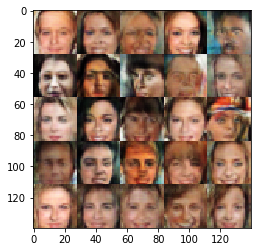

Epoch 1/1 ...  Discriminator loss = 0.393559 Generator loss = 3.241056
Epoch 1/1 ...  Discriminator loss = 0.397050 Generator loss = 4.275982
Epoch 1/1 ...  Discriminator loss = 0.396719 Generator loss = 4.219321
Epoch 1/1 ...  Discriminator loss = 0.450074 Generator loss = 3.047806
Epoch 1/1 ...  Discriminator loss = 0.378196 Generator loss = 2.988106
Epoch 1/1 ...  Discriminator loss = 0.460010 Generator loss = 3.382662
Epoch 1/1 ...  Discriminator loss = 0.428974 Generator loss = 4.062182
Epoch 1/1 ...  Discriminator loss = 0.501454 Generator loss = 4.819758
Epoch 1/1 ...  Discriminator loss = 0.403015 Generator loss = 3.837038
Epoch 1/1 ...  Discriminator loss = 0.443051 Generator loss = 3.470180


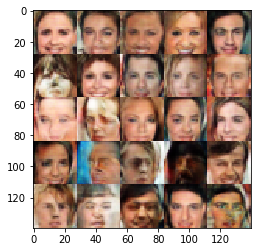

Epoch 1/1 ...  Discriminator loss = 0.424345 Generator loss = 2.788267
Epoch 1/1 ...  Discriminator loss = 0.361931 Generator loss = 4.607946
Epoch 1/1 ...  Discriminator loss = 0.517378 Generator loss = 3.583290
Epoch 1/1 ...  Discriminator loss = 0.347419 Generator loss = 3.563669
Epoch 1/1 ...  Discriminator loss = 0.401265 Generator loss = 3.555485
Epoch 1/1 ...  Discriminator loss = 0.355447 Generator loss = 3.457435
Epoch 1/1 ...  Discriminator loss = 0.466926 Generator loss = 4.630658
Epoch 1/1 ...  Discriminator loss = 0.389473 Generator loss = 4.058859
Epoch 1/1 ...  Discriminator loss = 0.447434 Generator loss = 4.284105
Epoch 1/1 ...  Discriminator loss = 0.391820 Generator loss = 2.806923


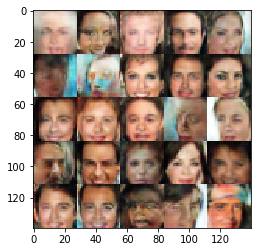

Epoch 1/1 ...  Discriminator loss = 0.390479 Generator loss = 5.431185
Epoch 1/1 ...  Discriminator loss = 0.512163 Generator loss = 2.734810
Epoch 1/1 ...  Discriminator loss = 0.379202 Generator loss = 3.288846
Epoch 1/1 ...  Discriminator loss = 0.378216 Generator loss = 3.713525
Epoch 1/1 ...  Discriminator loss = 0.387293 Generator loss = 2.998594
Epoch 1/1 ...  Discriminator loss = 0.382291 Generator loss = 3.890630
Epoch 1/1 ...  Discriminator loss = 0.433212 Generator loss = 3.065145
Epoch 1/1 ...  Discriminator loss = 0.442785 Generator loss = 2.691693
Epoch 1/1 ...  Discriminator loss = 0.430570 Generator loss = 3.721885
Epoch 1/1 ...  Discriminator loss = 0.361810 Generator loss = 4.644479


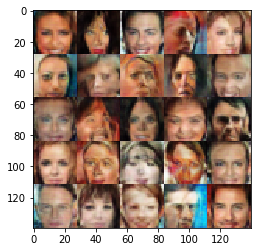

Epoch 1/1 ...  Discriminator loss = 0.427396 Generator loss = 3.099664
Epoch 1/1 ...  Discriminator loss = 0.418426 Generator loss = 4.286554
Epoch 1/1 ...  Discriminator loss = 0.395339 Generator loss = 3.966190
Epoch 1/1 ...  Discriminator loss = 0.420184 Generator loss = 3.490743
Epoch 1/1 ...  Discriminator loss = 0.451871 Generator loss = 2.467649
Epoch 1/1 ...  Discriminator loss = 0.404106 Generator loss = 3.179859
Epoch 1/1 ...  Discriminator loss = 0.395627 Generator loss = 4.351645
Epoch 1/1 ...  Discriminator loss = 0.423585 Generator loss = 2.457494
Epoch 1/1 ...  Discriminator loss = 0.366585 Generator loss = 4.294304
Epoch 1/1 ...  Discriminator loss = 0.430558 Generator loss = 4.663270


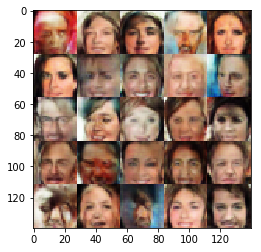

Epoch 1/1 ...  Discriminator loss = 0.360182 Generator loss = 3.856905
Epoch 1/1 ...  Discriminator loss = 0.413899 Generator loss = 4.272397
Epoch 1/1 ...  Discriminator loss = 0.542327 Generator loss = 4.504323
Epoch 1/1 ...  Discriminator loss = 0.660432 Generator loss = 2.452975
Epoch 1/1 ...  Discriminator loss = 0.452214 Generator loss = 3.424716
Epoch 1/1 ...  Discriminator loss = 0.390251 Generator loss = 3.915431
Epoch 1/1 ...  Discriminator loss = 0.444864 Generator loss = 2.945002
Epoch 1/1 ...  Discriminator loss = 0.409173 Generator loss = 3.555431
Epoch 1/1 ...  Discriminator loss = 0.382999 Generator loss = 4.685628
Epoch 1/1 ...  Discriminator loss = 0.406373 Generator loss = 2.702070


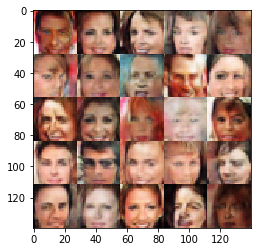

Epoch 1/1 ...  Discriminator loss = 0.404887 Generator loss = 3.855483
Epoch 1/1 ...  Discriminator loss = 0.381982 Generator loss = 5.117599
Epoch 1/1 ...  Discriminator loss = 0.405902 Generator loss = 3.199998
Epoch 1/1 ...  Discriminator loss = 0.419802 Generator loss = 3.019516
Epoch 1/1 ...  Discriminator loss = 0.471280 Generator loss = 3.741368
Epoch 1/1 ...  Discriminator loss = 0.388537 Generator loss = 4.325840
Epoch 1/1 ...  Discriminator loss = 0.417470 Generator loss = 3.051816
Epoch 1/1 ...  Discriminator loss = 0.377753 Generator loss = 4.512527
Epoch 1/1 ...  Discriminator loss = 0.415019 Generator loss = 3.834606
Epoch 1/1 ...  Discriminator loss = 0.487171 Generator loss = 2.430367


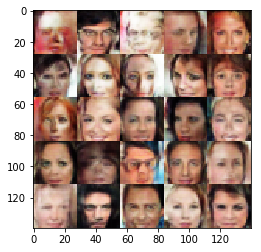

Epoch 1/1 ...  Discriminator loss = 1.069650 Generator loss = 2.486322
Epoch 1/1 ...  Discriminator loss = 0.382252 Generator loss = 4.468868
Epoch 1/1 ...  Discriminator loss = 0.430607 Generator loss = 2.390915
Epoch 1/1 ...  Discriminator loss = 0.445690 Generator loss = 2.455420
Epoch 1/1 ...  Discriminator loss = 0.411795 Generator loss = 3.188746
Epoch 1/1 ...  Discriminator loss = 0.383297 Generator loss = 4.463621
Epoch 1/1 ...  Discriminator loss = 0.450374 Generator loss = 3.102738
Epoch 1/1 ...  Discriminator loss = 0.401992 Generator loss = 4.711185
Epoch 1/1 ...  Discriminator loss = 0.383723 Generator loss = 4.503424
Epoch 1/1 ...  Discriminator loss = 0.405320 Generator loss = 3.084031


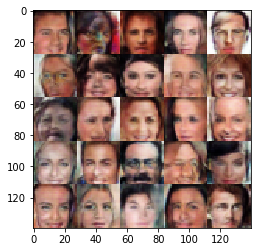

Epoch 1/1 ...  Discriminator loss = 0.399751 Generator loss = 3.870118
Epoch 1/1 ...  Discriminator loss = 2.038185 Generator loss = 3.412161
Epoch 1/1 ...  Discriminator loss = 0.418970 Generator loss = 2.635585
Epoch 1/1 ...  Discriminator loss = 0.412888 Generator loss = 2.903615
Epoch 1/1 ...  Discriminator loss = 0.500177 Generator loss = 4.210666
Epoch 1/1 ...  Discriminator loss = 0.358564 Generator loss = 3.887021
Epoch 1/1 ...  Discriminator loss = 0.383832 Generator loss = 3.233525
Epoch 1/1 ...  Discriminator loss = 0.433431 Generator loss = 2.964144
Epoch 1/1 ...  Discriminator loss = 0.476153 Generator loss = 4.909024
Epoch 1/1 ...  Discriminator loss = 0.380218 Generator loss = 4.064324


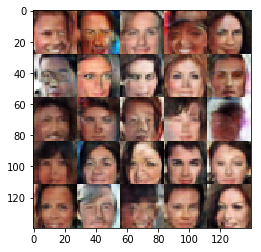

Epoch 1/1 ...  Discriminator loss = 0.418069 Generator loss = 3.132426
Epoch 1/1 ...  Discriminator loss = 0.498733 Generator loss = 4.655677
Epoch 1/1 ...  Discriminator loss = 0.374697 Generator loss = 3.345584
Epoch 1/1 ...  Discriminator loss = 0.367109 Generator loss = 3.285990
Epoch 1/1 ...  Discriminator loss = 0.459688 Generator loss = 3.537251
Epoch 1/1 ...  Discriminator loss = 0.391633 Generator loss = 3.894175
Epoch 1/1 ...  Discriminator loss = 0.479315 Generator loss = 4.022000
Epoch 1/1 ...  Discriminator loss = 0.446744 Generator loss = 2.494216
Epoch 1/1 ...  Discriminator loss = 0.405897 Generator loss = 3.740463
Epoch 1/1 ...  Discriminator loss = 0.415451 Generator loss = 4.658671


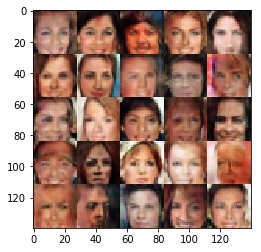

Epoch 1/1 ...  Discriminator loss = 0.421284 Generator loss = 2.284619
Epoch 1/1 ...  Discriminator loss = 0.462000 Generator loss = 2.366874
Epoch 1/1 ...  Discriminator loss = 0.370302 Generator loss = 4.239042
Epoch 1/1 ...  Discriminator loss = 0.640676 Generator loss = 3.366266
Epoch 1/1 ...  Discriminator loss = 0.373969 Generator loss = 3.595334
Epoch 1/1 ...  Discriminator loss = 0.484496 Generator loss = 2.094412
Epoch 1/1 ...  Discriminator loss = 0.513742 Generator loss = 1.813763
Epoch 1/1 ...  Discriminator loss = 0.545944 Generator loss = 2.200091
Epoch 1/1 ...  Discriminator loss = 0.493069 Generator loss = 3.583631
Epoch 1/1 ...  Discriminator loss = 0.441179 Generator loss = 3.436296


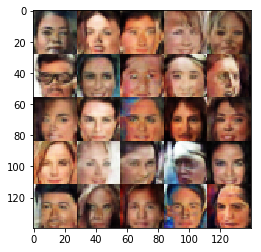

Epoch 1/1 ...  Discriminator loss = 0.392821 Generator loss = 4.338187
Epoch 1/1 ...  Discriminator loss = 0.377398 Generator loss = 3.687375
Epoch 1/1 ...  Discriminator loss = 0.362099 Generator loss = 4.080778
Epoch 1/1 ...  Discriminator loss = 0.411913 Generator loss = 3.771507
Epoch 1/1 ...  Discriminator loss = 0.393249 Generator loss = 3.125550
Epoch 1/1 ...  Discriminator loss = 0.480718 Generator loss = 2.278733
Epoch 1/1 ...  Discriminator loss = 0.409379 Generator loss = 5.069733
Epoch 1/1 ...  Discriminator loss = 0.500343 Generator loss = 4.259592
Epoch 1/1 ...  Discriminator loss = 0.491289 Generator loss = 4.656318
Epoch 1/1 ...  Discriminator loss = 0.409014 Generator loss = 3.387444


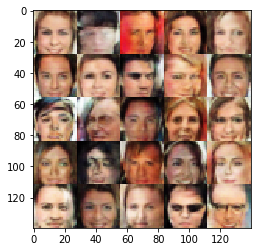

Epoch 1/1 ...  Discriminator loss = 0.383489 Generator loss = 2.468519
Epoch 1/1 ...  Discriminator loss = 0.388304 Generator loss = 5.456509
Epoch 1/1 ...  Discriminator loss = 0.458393 Generator loss = 2.036106
Epoch 1/1 ...  Discriminator loss = 0.363769 Generator loss = 4.128270
Epoch 1/1 ...  Discriminator loss = 0.355451 Generator loss = 2.631363
Epoch 1/1 ...  Discriminator loss = 0.413880 Generator loss = 4.405939
Epoch 1/1 ...  Discriminator loss = 0.371000 Generator loss = 4.131493
Epoch 1/1 ...  Discriminator loss = 0.398474 Generator loss = 3.955854
Epoch 1/1 ...  Discriminator loss = 0.439679 Generator loss = 3.244880
Epoch 1/1 ...  Discriminator loss = 0.370575 Generator loss = 3.234188


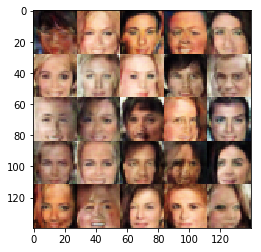

Epoch 1/1 ...  Discriminator loss = 0.471990 Generator loss = 6.067553
Epoch 1/1 ...  Discriminator loss = 0.460346 Generator loss = 3.363133
Epoch 1/1 ...  Discriminator loss = 0.458009 Generator loss = 2.972657
Epoch 1/1 ...  Discriminator loss = 0.388111 Generator loss = 4.476625
Epoch 1/1 ...  Discriminator loss = 0.554938 Generator loss = 3.853317
Epoch 1/1 ...  Discriminator loss = 0.376356 Generator loss = 4.682709
Epoch 1/1 ...  Discriminator loss = 0.433684 Generator loss = 2.704047
Epoch 1/1 ...  Discriminator loss = 0.409004 Generator loss = 2.965713
Epoch 1/1 ...  Discriminator loss = 0.462501 Generator loss = 3.725992
Epoch 1/1 ...  Discriminator loss = 0.425527 Generator loss = 4.388709


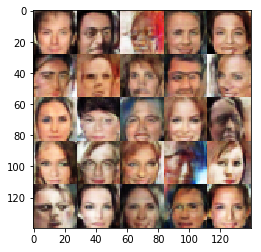

Epoch 1/1 ...  Discriminator loss = 0.401828 Generator loss = 3.458111
Epoch 1/1 ...  Discriminator loss = 0.401245 Generator loss = 3.413711
Epoch 1/1 ...  Discriminator loss = 0.420659 Generator loss = 6.427188
Epoch 1/1 ...  Discriminator loss = 0.430021 Generator loss = 2.550296
Epoch 1/1 ...  Discriminator loss = 0.436136 Generator loss = 2.765315
Epoch 1/1 ...  Discriminator loss = 0.393554 Generator loss = 3.665884
Epoch 1/1 ...  Discriminator loss = 0.397875 Generator loss = 3.365115
Epoch 1/1 ...  Discriminator loss = 0.424757 Generator loss = 2.597985
Epoch 1/1 ...  Discriminator loss = 0.420305 Generator loss = 4.298422
Epoch 1/1 ...  Discriminator loss = 0.348658 Generator loss = 3.207553


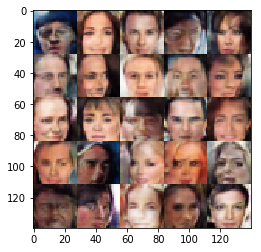

Epoch 1/1 ...  Discriminator loss = 0.358548 Generator loss = 4.332334
Epoch 1/1 ...  Discriminator loss = 0.367853 Generator loss = 3.379067
Epoch 1/1 ...  Discriminator loss = 0.421962 Generator loss = 3.555323
Epoch 1/1 ...  Discriminator loss = 0.377147 Generator loss = 5.177672
Epoch 1/1 ...  Discriminator loss = 0.692243 Generator loss = 2.424907
Epoch 1/1 ...  Discriminator loss = 0.436534 Generator loss = 2.815290
Epoch 1/1 ...  Discriminator loss = 0.385163 Generator loss = 3.936470
Epoch 1/1 ...  Discriminator loss = 0.365275 Generator loss = 4.346615
Epoch 1/1 ...  Discriminator loss = 0.391606 Generator loss = 3.420668
Epoch 1/1 ...  Discriminator loss = 0.370655 Generator loss = 4.437654


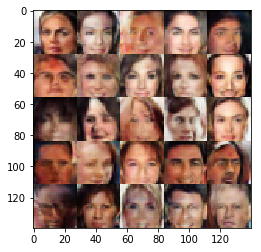

Epoch 1/1 ...  Discriminator loss = 0.449332 Generator loss = 2.582245
Epoch 1/1 ...  Discriminator loss = 0.420908 Generator loss = 4.040195
Epoch 1/1 ...  Discriminator loss = 0.448451 Generator loss = 4.490328
Epoch 1/1 ...  Discriminator loss = 0.432095 Generator loss = 3.486917
Epoch 1/1 ...  Discriminator loss = 0.382398 Generator loss = 2.502141
Epoch 1/1 ...  Discriminator loss = 0.395903 Generator loss = 4.413766
Epoch 1/1 ...  Discriminator loss = 0.406966 Generator loss = 2.769473
Epoch 1/1 ...  Discriminator loss = 0.386033 Generator loss = 3.580618
Epoch 1/1 ...  Discriminator loss = 0.518866 Generator loss = 4.626815
Epoch 1/1 ...  Discriminator loss = 0.467145 Generator loss = 2.129684


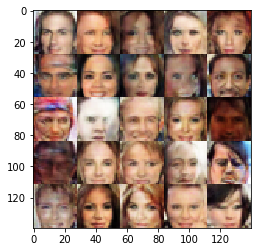

Epoch 1/1 ...  Discriminator loss = 0.451830 Generator loss = 3.577561
Epoch 1/1 ...  Discriminator loss = 0.377958 Generator loss = 4.403133
Epoch 1/1 ...  Discriminator loss = 0.392192 Generator loss = 3.060173
Epoch 1/1 ...  Discriminator loss = 0.379241 Generator loss = 3.309510
Epoch 1/1 ...  Discriminator loss = 0.379718 Generator loss = 3.927509
Epoch 1/1 ...  Discriminator loss = 0.521997 Generator loss = 2.819613
Epoch 1/1 ...  Discriminator loss = 0.408599 Generator loss = 3.853001
Epoch 1/1 ...  Discriminator loss = 0.401257 Generator loss = 2.623992
Epoch 1/1 ...  Discriminator loss = 0.404245 Generator loss = 3.074260
Epoch 1/1 ...  Discriminator loss = 0.407938 Generator loss = 3.809558


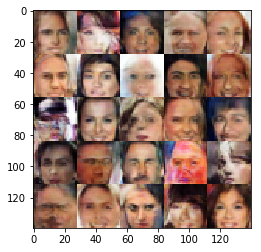

Epoch 1/1 ...  Discriminator loss = 0.391746 Generator loss = 3.337834
Epoch 1/1 ...  Discriminator loss = 0.399255 Generator loss = 4.408924
Epoch 1/1 ...  Discriminator loss = 0.413501 Generator loss = 4.412782
Epoch 1/1 ...  Discriminator loss = 0.427461 Generator loss = 3.277647
Epoch 1/1 ...  Discriminator loss = 0.392536 Generator loss = 3.159429
Epoch 1/1 ...  Discriminator loss = 0.967574 Generator loss = 3.521933
Epoch 1/1 ...  Discriminator loss = 0.364905 Generator loss = 3.087841
Epoch 1/1 ...  Discriminator loss = 0.401444 Generator loss = 3.920778
Epoch 1/1 ...  Discriminator loss = 0.659401 Generator loss = 3.913395
Epoch 1/1 ...  Discriminator loss = 0.418931 Generator loss = 3.437010


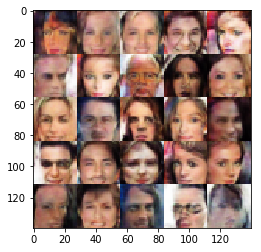

Epoch 1/1 ...  Discriminator loss = 0.423403 Generator loss = 3.352325
Epoch 1/1 ...  Discriminator loss = 0.412609 Generator loss = 3.381175
Epoch 1/1 ...  Discriminator loss = 0.421097 Generator loss = 3.273782
Epoch 1/1 ...  Discriminator loss = 0.479764 Generator loss = 3.427771
Epoch 1/1 ...  Discriminator loss = 0.391358 Generator loss = 3.988168
Epoch 1/1 ...  Discriminator loss = 0.418146 Generator loss = 3.824746
Epoch 1/1 ...  Discriminator loss = 0.355903 Generator loss = 3.682035
Epoch 1/1 ...  Discriminator loss = 0.398047 Generator loss = 3.881874
Epoch 1/1 ...  Discriminator loss = 0.436705 Generator loss = 3.292409
Epoch 1/1 ...  Discriminator loss = 0.466911 Generator loss = 3.335700


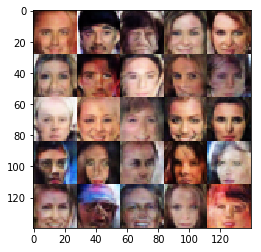

Epoch 1/1 ...  Discriminator loss = 0.445365 Generator loss = 1.459839
Epoch 1/1 ...  Discriminator loss = 0.387508 Generator loss = 3.498251
Epoch 1/1 ...  Discriminator loss = 0.411890 Generator loss = 3.645242
Epoch 1/1 ...  Discriminator loss = 0.380635 Generator loss = 4.066527
Epoch 1/1 ...  Discriminator loss = 0.385762 Generator loss = 3.458957
Epoch 1/1 ...  Discriminator loss = 0.476481 Generator loss = 2.967762
Epoch 1/1 ...  Discriminator loss = 0.376223 Generator loss = 3.500991
Epoch 1/1 ...  Discriminator loss = 0.381324 Generator loss = 5.039279
Epoch 1/1 ...  Discriminator loss = 0.400515 Generator loss = 5.106157
Epoch 1/1 ...  Discriminator loss = 0.541010 Generator loss = 4.432079


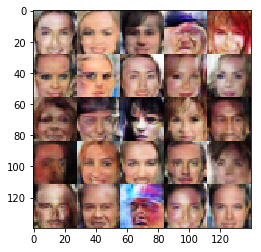

Epoch 1/1 ...  Discriminator loss = 0.338489 Generator loss = 3.522926
Epoch 1/1 ...  Discriminator loss = 0.590823 Generator loss = 3.303745
Epoch 1/1 ...  Discriminator loss = 0.365292 Generator loss = 3.117857
Epoch 1/1 ...  Discriminator loss = 0.385658 Generator loss = 3.814279
Epoch 1/1 ...  Discriminator loss = 0.494749 Generator loss = 2.767978
Epoch 1/1 ...  Discriminator loss = 0.658143 Generator loss = 2.591376
Epoch 1/1 ...  Discriminator loss = 0.420340 Generator loss = 2.468867
Epoch 1/1 ...  Discriminator loss = 0.401151 Generator loss = 2.264650
Epoch 1/1 ...  Discriminator loss = 0.422913 Generator loss = 2.441584
Epoch 1/1 ...  Discriminator loss = 0.414442 Generator loss = 3.253613


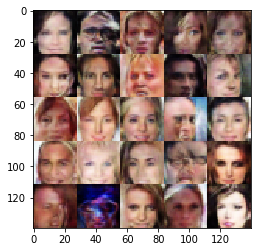

Epoch 1/1 ...  Discriminator loss = 0.463644 Generator loss = 3.378486
Epoch 1/1 ...  Discriminator loss = 0.393527 Generator loss = 3.317509
Epoch 1/1 ...  Discriminator loss = 0.461681 Generator loss = 3.074938
Epoch 1/1 ...  Discriminator loss = 0.401344 Generator loss = 5.077365
Epoch 1/1 ...  Discriminator loss = 0.378603 Generator loss = 2.647306
Epoch 1/1 ...  Discriminator loss = 0.412781 Generator loss = 3.332577
Epoch 1/1 ...  Discriminator loss = 0.396331 Generator loss = 3.196429
Epoch 1/1 ...  Discriminator loss = 0.391339 Generator loss = 2.755869
Epoch 1/1 ...  Discriminator loss = 0.508206 Generator loss = 2.821765
Epoch 1/1 ...  Discriminator loss = 0.447461 Generator loss = 3.046643


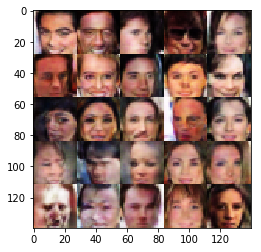

Epoch 1/1 ...  Discriminator loss = 0.370354 Generator loss = 3.782445
Epoch 1/1 ...  Discriminator loss = 0.447129 Generator loss = 3.527888
Epoch 1/1 ...  Discriminator loss = 0.681152 Generator loss = 3.215284
Epoch 1/1 ...  Discriminator loss = 0.389020 Generator loss = 2.521741
Epoch 1/1 ...  Discriminator loss = 0.363753 Generator loss = 3.624428
Epoch 1/1 ...  Discriminator loss = 0.451385 Generator loss = 3.891850
Epoch 1/1 ...  Discriminator loss = 0.502796 Generator loss = 2.619381
Epoch 1/1 ...  Discriminator loss = 0.417525 Generator loss = 3.086079
Epoch 1/1 ...  Discriminator loss = 0.424711 Generator loss = 3.165890
Epoch 1/1 ...  Discriminator loss = 0.355139 Generator loss = 5.084325


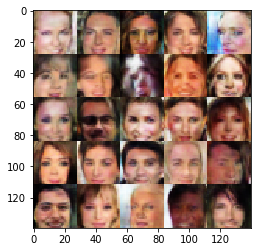

Epoch 1/1 ...  Discriminator loss = 0.551376 Generator loss = 2.415787
Epoch 1/1 ...  Discriminator loss = 0.422881 Generator loss = 4.195130
Epoch 1/1 ...  Discriminator loss = 0.452934 Generator loss = 3.544756
Epoch 1/1 ...  Discriminator loss = 0.424497 Generator loss = 2.989375
Epoch 1/1 ...  Discriminator loss = 0.390504 Generator loss = 3.620579
Epoch 1/1 ...  Discriminator loss = 0.458874 Generator loss = 4.536613
Epoch 1/1 ...  Discriminator loss = 0.443803 Generator loss = 2.996909
Epoch 1/1 ...  Discriminator loss = 0.410812 Generator loss = 3.526423
Epoch 1/1 ...  Discriminator loss = 1.071347 Generator loss = 2.873668
Epoch 1/1 ...  Discriminator loss = 0.407845 Generator loss = 2.441779


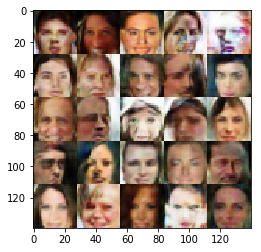

Epoch 1/1 ...  Discriminator loss = 0.601607 Generator loss = 3.351944
Epoch 1/1 ...  Discriminator loss = 0.375433 Generator loss = 2.488467
Epoch 1/1 ...  Discriminator loss = 0.396968 Generator loss = 3.212206
Epoch 1/1 ...  Discriminator loss = 0.361605 Generator loss = 4.321053
Epoch 1/1 ...  Discriminator loss = 0.371376 Generator loss = 5.409402
Epoch 1/1 ...  Discriminator loss = 0.386458 Generator loss = 3.489359
Epoch 1/1 ...  Discriminator loss = 0.377225 Generator loss = 3.094351
Epoch 1/1 ...  Discriminator loss = 0.384994 Generator loss = 2.790764
Epoch 1/1 ...  Discriminator loss = 0.483113 Generator loss = 4.556603
Epoch 1/1 ...  Discriminator loss = 0.501586 Generator loss = 1.864441


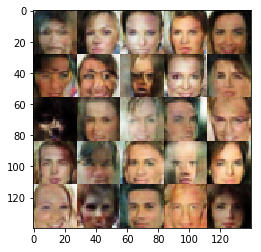

Epoch 1/1 ...  Discriminator loss = 0.394147 Generator loss = 3.831224
Epoch 1/1 ...  Discriminator loss = 0.501208 Generator loss = 3.552791
Epoch 1/1 ...  Discriminator loss = 0.409964 Generator loss = 3.408497
Epoch 1/1 ...  Discriminator loss = 0.383187 Generator loss = 4.684764
Epoch 1/1 ...  Discriminator loss = 0.414876 Generator loss = 4.235992
Epoch 1/1 ...  Discriminator loss = 0.435004 Generator loss = 3.665642
Epoch 1/1 ...  Discriminator loss = 0.536479 Generator loss = 2.331906
Epoch 1/1 ...  Discriminator loss = 0.383496 Generator loss = 2.265681
Epoch 1/1 ...  Discriminator loss = 0.489870 Generator loss = 5.195394
Epoch 1/1 ...  Discriminator loss = 0.488995 Generator loss = 3.544203


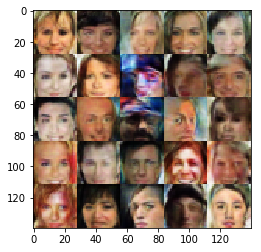

Epoch 1/1 ...  Discriminator loss = 0.408594 Generator loss = 5.473647
Epoch 1/1 ...  Discriminator loss = 0.403944 Generator loss = 3.637854
Epoch 1/1 ...  Discriminator loss = 0.404609 Generator loss = 2.356098
Epoch 1/1 ...  Discriminator loss = 0.417017 Generator loss = 3.987372
Epoch 1/1 ...  Discriminator loss = 0.426067 Generator loss = 2.347026
Epoch 1/1 ...  Discriminator loss = 0.432052 Generator loss = 2.068969
Epoch 1/1 ...  Discriminator loss = 0.391128 Generator loss = 4.536582
Epoch 1/1 ...  Discriminator loss = 0.495654 Generator loss = 3.956615
Epoch 1/1 ...  Discriminator loss = 0.401686 Generator loss = 1.881305
Epoch 1/1 ...  Discriminator loss = 0.387472 Generator loss = 3.964645


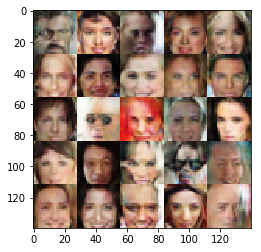

Epoch 1/1 ...  Discriminator loss = 0.641470 Generator loss = 2.737357
Epoch 1/1 ...  Discriminator loss = 0.376443 Generator loss = 2.888093
Epoch 1/1 ...  Discriminator loss = 0.435559 Generator loss = 4.460241
Epoch 1/1 ...  Discriminator loss = 0.546422 Generator loss = 2.520099
Epoch 1/1 ...  Discriminator loss = 0.427904 Generator loss = 3.325394
Epoch 1/1 ...  Discriminator loss = 0.514209 Generator loss = 2.079517
Epoch 1/1 ...  Discriminator loss = 0.372000 Generator loss = 3.768599
Epoch 1/1 ...  Discriminator loss = 0.495680 Generator loss = 3.469262
Epoch 1/1 ...  Discriminator loss = 0.398645 Generator loss = 5.236421
Epoch 1/1 ...  Discriminator loss = 0.438319 Generator loss = 2.042359


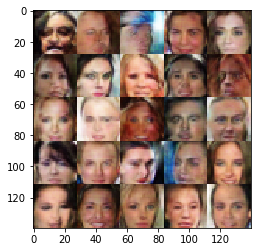

Epoch 1/1 ...  Discriminator loss = 0.561289 Generator loss = 3.266631
Epoch 1/1 ...  Discriminator loss = 0.507121 Generator loss = 3.776659
Epoch 1/1 ...  Discriminator loss = 0.601064 Generator loss = 2.687689
Epoch 1/1 ...  Discriminator loss = 0.428961 Generator loss = 4.125804
Epoch 1/1 ...  Discriminator loss = 0.432991 Generator loss = 3.603667
Epoch 1/1 ...  Discriminator loss = 0.449336 Generator loss = 4.030227
Epoch 1/1 ...  Discriminator loss = 0.513905 Generator loss = 3.026013
Epoch 1/1 ...  Discriminator loss = 0.555147 Generator loss = 3.528785
Epoch 1/1 ...  Discriminator loss = 0.430689 Generator loss = 3.164615
Epoch 1/1 ...  Discriminator loss = 0.365822 Generator loss = 3.458189


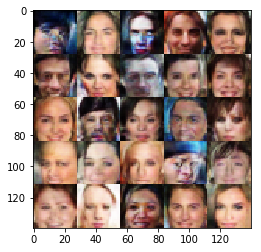

Epoch 1/1 ...  Discriminator loss = 0.478132 Generator loss = 3.747480
Epoch 1/1 ...  Discriminator loss = 0.419681 Generator loss = 3.120608
Epoch 1/1 ...  Discriminator loss = 0.616589 Generator loss = 3.813941
Epoch 1/1 ...  Discriminator loss = 0.377613 Generator loss = 4.200450
Epoch 1/1 ...  Discriminator loss = 0.383242 Generator loss = 3.788218
Epoch 1/1 ...  Discriminator loss = 0.475677 Generator loss = 2.644353
Epoch 1/1 ...  Discriminator loss = 0.396695 Generator loss = 3.082875
Epoch 1/1 ...  Discriminator loss = 0.405691 Generator loss = 3.834326
Epoch 1/1 ...  Discriminator loss = 0.392753 Generator loss = 3.741249
Epoch 1/1 ...  Discriminator loss = 0.475266 Generator loss = 2.894798


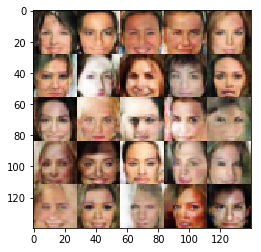

Epoch 1/1 ...  Discriminator loss = 0.913053 Generator loss = 3.357333
Epoch 1/1 ...  Discriminator loss = 0.463851 Generator loss = 2.754352
Epoch 1/1 ...  Discriminator loss = 0.368607 Generator loss = 4.455304
Epoch 1/1 ...  Discriminator loss = 0.495821 Generator loss = 4.060471
Epoch 1/1 ...  Discriminator loss = 0.403701 Generator loss = 3.772093
Epoch 1/1 ...  Discriminator loss = 0.393921 Generator loss = 3.489756
Epoch 1/1 ...  Discriminator loss = 0.476921 Generator loss = 4.364808
Epoch 1/1 ...  Discriminator loss = 0.378484 Generator loss = 4.279407
Epoch 1/1 ...  Discriminator loss = 0.475079 Generator loss = 1.108839
Epoch 1/1 ...  Discriminator loss = 0.420282 Generator loss = 3.917322


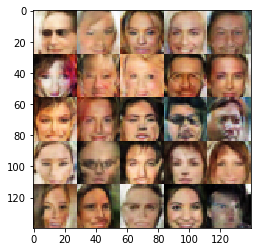

Epoch 1/1 ...  Discriminator loss = 0.521855 Generator loss = 3.012510
Epoch 1/1 ...  Discriminator loss = 0.354672 Generator loss = 2.797304
Epoch 1/1 ...  Discriminator loss = 0.465222 Generator loss = 4.051674
Epoch 1/1 ...  Discriminator loss = 0.511330 Generator loss = 2.419982
Epoch 1/1 ...  Discriminator loss = 0.369577 Generator loss = 4.682600
Epoch 1/1 ...  Discriminator loss = 0.491282 Generator loss = 2.643799
Epoch 1/1 ...  Discriminator loss = 0.439380 Generator loss = 3.580978
Epoch 1/1 ...  Discriminator loss = 0.378809 Generator loss = 2.916852
Epoch 1/1 ...  Discriminator loss = 0.418713 Generator loss = 1.918884
Epoch 1/1 ...  Discriminator loss = 0.407826 Generator loss = 3.631770


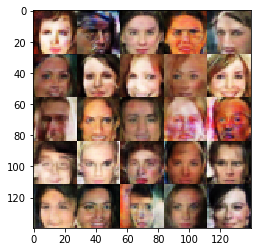

Epoch 1/1 ...  Discriminator loss = 0.356108 Generator loss = 4.176930
Epoch 1/1 ...  Discriminator loss = 0.389476 Generator loss = 4.688178
Epoch 1/1 ...  Discriminator loss = 0.428055 Generator loss = 3.314389
Epoch 1/1 ...  Discriminator loss = 0.515135 Generator loss = 2.692041
Epoch 1/1 ...  Discriminator loss = 0.536918 Generator loss = 2.714386
Epoch 1/1 ...  Discriminator loss = 0.414766 Generator loss = 3.950854
Epoch 1/1 ...  Discriminator loss = 0.390807 Generator loss = 3.187961
Epoch 1/1 ...  Discriminator loss = 0.384080 Generator loss = 4.003641
Epoch 1/1 ...  Discriminator loss = 0.372974 Generator loss = 3.317325
Epoch 1/1 ...  Discriminator loss = 0.419007 Generator loss = 3.514177


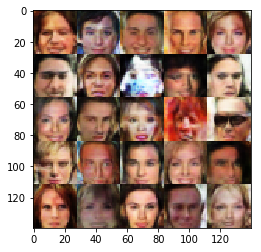

Epoch 1/1 ...  Discriminator loss = 0.389465 Generator loss = 3.273098
Epoch 1/1 ...  Discriminator loss = 0.410581 Generator loss = 2.700020
Epoch 1/1 ...  Discriminator loss = 0.465297 Generator loss = 3.892257
Epoch 1/1 ...  Discriminator loss = 0.401850 Generator loss = 3.665852
Epoch 1/1 ...  Discriminator loss = 0.358476 Generator loss = 2.982271
Epoch 1/1 ...  Discriminator loss = 0.361865 Generator loss = 4.181557
Epoch 1/1 ...  Discriminator loss = 0.364539 Generator loss = 3.786968
Epoch 1/1 ...  Discriminator loss = 0.392168 Generator loss = 3.393307
Epoch 1/1 ...  Discriminator loss = 0.414234 Generator loss = 3.322619
Epoch 1/1 ...  Discriminator loss = 0.397153 Generator loss = 4.052738


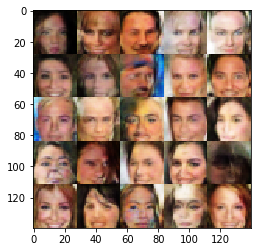

Epoch 1/1 ...  Discriminator loss = 0.411160 Generator loss = 2.946527
Epoch 1/1 ...  Discriminator loss = 0.478794 Generator loss = 2.206307
Epoch 1/1 ...  Discriminator loss = 0.597128 Generator loss = 2.039004
Epoch 1/1 ...  Discriminator loss = 0.382018 Generator loss = 5.229872
Epoch 1/1 ...  Discriminator loss = 0.611177 Generator loss = 2.403782
Epoch 1/1 ...  Discriminator loss = 0.404436 Generator loss = 3.190171
Epoch 1/1 ...  Discriminator loss = 0.441663 Generator loss = 3.141233
Epoch 1/1 ...  Discriminator loss = 0.536670 Generator loss = 3.340142
Epoch 1/1 ...  Discriminator loss = 0.362152 Generator loss = 3.185700
Epoch 1/1 ...  Discriminator loss = 0.364902 Generator loss = 3.090024


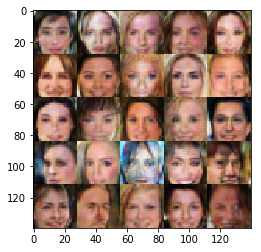

Epoch 1/1 ...  Discriminator loss = 0.370894 Generator loss = 4.719681
Epoch 1/1 ...  Discriminator loss = 0.397372 Generator loss = 3.203285
Epoch 1/1 ...  Discriminator loss = 0.437674 Generator loss = 3.809256
Epoch 1/1 ...  Discriminator loss = 0.442116 Generator loss = 2.740443
Epoch 1/1 ...  Discriminator loss = 0.370828 Generator loss = 3.356034
Epoch 1/1 ...  Discriminator loss = 0.356151 Generator loss = 2.805899
Epoch 1/1 ...  Discriminator loss = 0.487319 Generator loss = 3.941082
Epoch 1/1 ...  Discriminator loss = 0.436101 Generator loss = 3.437019
Epoch 1/1 ...  Discriminator loss = 0.399351 Generator loss = 2.536337
Epoch 1/1 ...  Discriminator loss = 0.386870 Generator loss = 3.599836


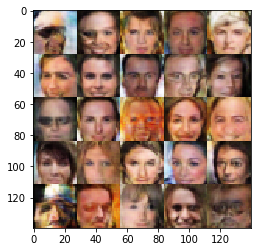

Epoch 1/1 ...  Discriminator loss = 0.395148 Generator loss = 2.736860
Epoch 1/1 ...  Discriminator loss = 0.412547 Generator loss = 3.943545
Epoch 1/1 ...  Discriminator loss = 0.428690 Generator loss = 2.576259
Epoch 1/1 ...  Discriminator loss = 0.383387 Generator loss = 4.010095
Epoch 1/1 ...  Discriminator loss = 0.402627 Generator loss = 3.758854
Epoch 1/1 ...  Discriminator loss = 0.416626 Generator loss = 4.687914
Epoch 1/1 ...  Discriminator loss = 0.384132 Generator loss = 3.657467
Epoch 1/1 ...  Discriminator loss = 0.389210 Generator loss = 3.114400
Epoch 1/1 ...  Discriminator loss = 0.381435 Generator loss = 3.580353
Epoch 1/1 ...  Discriminator loss = 0.438864 Generator loss = 2.064948


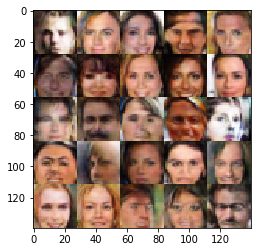

Epoch 1/1 ...  Discriminator loss = 0.382222 Generator loss = 4.112247
Epoch 1/1 ...  Discriminator loss = 0.424174 Generator loss = 3.885461
Epoch 1/1 ...  Discriminator loss = 0.428583 Generator loss = 2.033004
Epoch 1/1 ...  Discriminator loss = 0.440975 Generator loss = 2.567666
Epoch 1/1 ...  Discriminator loss = 0.582295 Generator loss = 5.033988
Epoch 1/1 ...  Discriminator loss = 0.426411 Generator loss = 2.624849
Epoch 1/1 ...  Discriminator loss = 0.388003 Generator loss = 4.922099
Epoch 1/1 ...  Discriminator loss = 0.481110 Generator loss = 2.760394
Epoch 1/1 ...  Discriminator loss = 0.776003 Generator loss = 3.052428
Epoch 1/1 ...  Discriminator loss = 0.363045 Generator loss = 4.370914


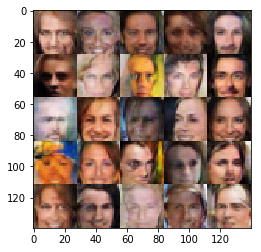

Epoch 1/1 ...  Discriminator loss = 0.390306 Generator loss = 3.610070
Epoch 1/1 ...  Discriminator loss = 0.474873 Generator loss = 3.393701
Epoch 1/1 ...  Discriminator loss = 0.448284 Generator loss = 2.851619
Epoch 1/1 ...  Discriminator loss = 0.445678 Generator loss = 1.704703
Epoch 1/1 ...  Discriminator loss = 0.400432 Generator loss = 3.078339
Epoch 1/1 ...  Discriminator loss = 0.433679 Generator loss = 3.787492
Epoch 1/1 ...  Discriminator loss = 0.403726 Generator loss = 4.002502
Epoch 1/1 ...  Discriminator loss = 0.374426 Generator loss = 3.020815
Epoch 1/1 ...  Discriminator loss = 0.379761 Generator loss = 3.512109
Epoch 1/1 ...  Discriminator loss = 0.430428 Generator loss = 3.631511


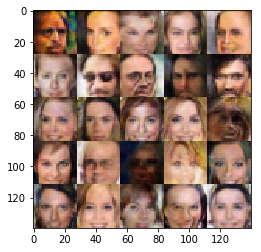

Epoch 1/1 ...  Discriminator loss = 0.419386 Generator loss = 2.839898
Epoch 1/1 ...  Discriminator loss = 0.389748 Generator loss = 5.875358
Epoch 1/1 ...  Discriminator loss = 0.462730 Generator loss = 4.125338
Epoch 1/1 ...  Discriminator loss = 0.459407 Generator loss = 3.032526
Epoch 1/1 ...  Discriminator loss = 0.426329 Generator loss = 3.547000
Epoch 1/1 ...  Discriminator loss = 0.400314 Generator loss = 5.133744
Epoch 1/1 ...  Discriminator loss = 0.421785 Generator loss = 3.714294
Epoch 1/1 ...  Discriminator loss = 0.432267 Generator loss = 2.581257
Epoch 1/1 ...  Discriminator loss = 0.385235 Generator loss = 2.988965
Epoch 1/1 ...  Discriminator loss = 0.398792 Generator loss = 1.954206


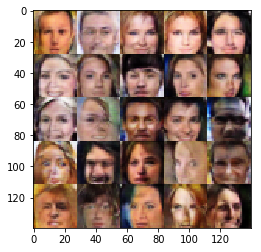

Epoch 1/1 ...  Discriminator loss = 0.507299 Generator loss = 3.608759
Epoch 1/1 ...  Discriminator loss = 0.435783 Generator loss = 3.852727
Epoch 1/1 ...  Discriminator loss = 0.404559 Generator loss = 2.730394
Epoch 1/1 ...  Discriminator loss = 0.397228 Generator loss = 3.577635
Epoch 1/1 ...  Discriminator loss = 0.381491 Generator loss = 3.799820
Epoch 1/1 ...  Discriminator loss = 0.442408 Generator loss = 4.322946
Epoch 1/1 ...  Discriminator loss = 0.511974 Generator loss = 4.581937
Epoch 1/1 ...  Discriminator loss = 0.560738 Generator loss = 2.914846
Epoch 1/1 ...  Discriminator loss = 0.497881 Generator loss = 4.259344
Epoch 1/1 ...  Discriminator loss = 0.570990 Generator loss = 3.815459


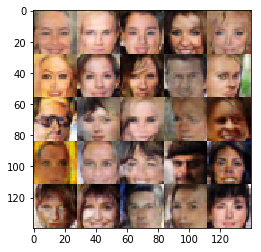

Epoch 1/1 ...  Discriminator loss = 0.507940 Generator loss = 3.196111
Epoch 1/1 ...  Discriminator loss = 0.575710 Generator loss = 3.351991
Epoch 1/1 ...  Discriminator loss = 0.371002 Generator loss = 4.521564
Epoch 1/1 ...  Discriminator loss = 0.457647 Generator loss = 2.783715
Epoch 1/1 ...  Discriminator loss = 0.421840 Generator loss = 3.478105
Epoch 1/1 ...  Discriminator loss = 0.445177 Generator loss = 2.767163
Epoch 1/1 ...  Discriminator loss = 0.375162 Generator loss = 3.626938
Epoch 1/1 ...  Discriminator loss = 0.377513 Generator loss = 4.477623
Epoch 1/1 ...  Discriminator loss = 0.464051 Generator loss = 2.708784
Epoch 1/1 ...  Discriminator loss = 0.491325 Generator loss = 1.883780


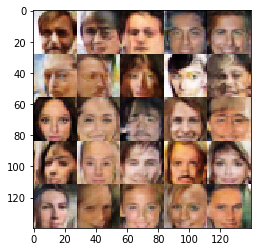

Epoch 1/1 ...  Discriminator loss = 0.366671 Generator loss = 4.482330
Epoch 1/1 ...  Discriminator loss = 0.415297 Generator loss = 3.173254
Epoch 1/1 ...  Discriminator loss = 0.361286 Generator loss = 3.348958
Epoch 1/1 ...  Discriminator loss = 0.407388 Generator loss = 3.527919
Epoch 1/1 ...  Discriminator loss = 0.523834 Generator loss = 2.959769
Epoch 1/1 ...  Discriminator loss = 0.357881 Generator loss = 3.196376
Epoch 1/1 ...  Discriminator loss = 0.386098 Generator loss = 4.371898
Epoch 1/1 ...  Discriminator loss = 0.440091 Generator loss = 5.006797
Epoch 1/1 ...  Discriminator loss = 0.577011 Generator loss = 4.838161
Epoch 1/1 ...  Discriminator loss = 0.477624 Generator loss = 3.466486


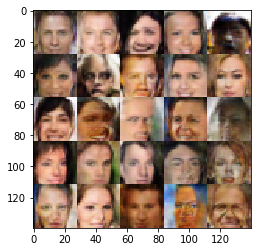

Epoch 1/1 ...  Discriminator loss = 0.375826 Generator loss = 3.683057
Epoch 1/1 ...  Discriminator loss = 0.441656 Generator loss = 2.596528
Epoch 1/1 ...  Discriminator loss = 0.362958 Generator loss = 4.922026
Epoch 1/1 ...  Discriminator loss = 0.414934 Generator loss = 4.190133
Epoch 1/1 ...  Discriminator loss = 0.437456 Generator loss = 3.489306
Epoch 1/1 ...  Discriminator loss = 0.458227 Generator loss = 1.930680
Epoch 1/1 ...  Discriminator loss = 0.411539 Generator loss = 3.682069
Epoch 1/1 ...  Discriminator loss = 0.470075 Generator loss = 4.055465
Epoch 1/1 ...  Discriminator loss = 0.437550 Generator loss = 3.364572
Epoch 1/1 ...  Discriminator loss = 0.429178 Generator loss = 3.427205


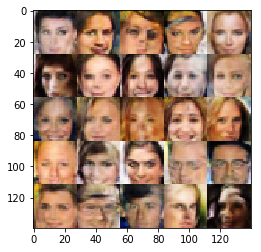

Epoch 1/1 ...  Discriminator loss = 0.421966 Generator loss = 3.379902
Epoch 1/1 ...  Discriminator loss = 0.527698 Generator loss = 2.827300
Epoch 1/1 ...  Discriminator loss = 0.457257 Generator loss = 3.476852
Epoch 1/1 ...  Discriminator loss = 0.353755 Generator loss = 4.152604
Epoch 1/1 ...  Discriminator loss = 0.474148 Generator loss = 4.127588
Epoch 1/1 ...  Discriminator loss = 0.442159 Generator loss = 2.607609
Epoch 1/1 ...  Discriminator loss = 0.409828 Generator loss = 3.353369
Epoch 1/1 ...  Discriminator loss = 0.421164 Generator loss = 4.138445
Epoch 1/1 ...  Discriminator loss = 0.385169 Generator loss = 2.899330
Epoch 1/1 ...  Discriminator loss = 0.635388 Generator loss = 2.586601


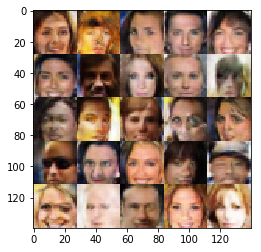

Epoch 1/1 ...  Discriminator loss = 0.407015 Generator loss = 2.590606
Epoch 1/1 ...  Discriminator loss = 0.369288 Generator loss = 4.845435
Epoch 1/1 ...  Discriminator loss = 0.390472 Generator loss = 4.897478
Epoch 1/1 ...  Discriminator loss = 0.455266 Generator loss = 1.911846
Epoch 1/1 ...  Discriminator loss = 0.429656 Generator loss = 4.840900
Epoch 1/1 ...  Discriminator loss = 0.413228 Generator loss = 3.576267
Epoch 1/1 ...  Discriminator loss = 0.467461 Generator loss = 2.094492
Epoch 1/1 ...  Discriminator loss = 0.396578 Generator loss = 1.756283
Epoch 1/1 ...  Discriminator loss = 0.368477 Generator loss = 4.853660
Epoch 1/1 ...  Discriminator loss = 0.459946 Generator loss = 3.684341


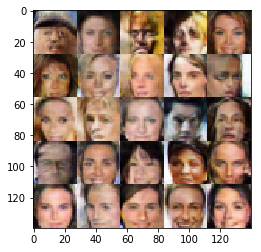

Epoch 1/1 ...  Discriminator loss = 0.407129 Generator loss = 1.977279
Epoch 1/1 ...  Discriminator loss = 0.475956 Generator loss = 3.654818
Epoch 1/1 ...  Discriminator loss = 0.417586 Generator loss = 3.325728
Epoch 1/1 ...  Discriminator loss = 0.638860 Generator loss = 3.123209
Epoch 1/1 ...  Discriminator loss = 0.451707 Generator loss = 3.411956
Epoch 1/1 ...  Discriminator loss = 0.402224 Generator loss = 3.352909
Epoch 1/1 ...  Discriminator loss = 0.363998 Generator loss = 3.992488
Epoch 1/1 ...  Discriminator loss = 0.409746 Generator loss = 3.353585
Epoch 1/1 ...  Discriminator loss = 0.498988 Generator loss = 2.473542
Epoch 1/1 ...  Discriminator loss = 0.382905 Generator loss = 4.364461


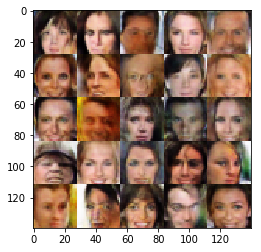

Epoch 1/1 ...  Discriminator loss = 0.486144 Generator loss = 3.913705
Epoch 1/1 ...  Discriminator loss = 0.366067 Generator loss = 3.969263
Epoch 1/1 ...  Discriminator loss = 0.431821 Generator loss = 3.695811
Epoch 1/1 ...  Discriminator loss = 0.400139 Generator loss = 2.754710
Epoch 1/1 ...  Discriminator loss = 0.431948 Generator loss = 3.721331
Epoch 1/1 ...  Discriminator loss = 0.397452 Generator loss = 4.878989
Epoch 1/1 ...  Discriminator loss = 0.467094 Generator loss = 3.903843
Epoch 1/1 ...  Discriminator loss = 0.619358 Generator loss = 1.653851
Epoch 1/1 ...  Discriminator loss = 0.374756 Generator loss = 4.611394
Epoch 1/1 ...  Discriminator loss = 0.518207 Generator loss = 3.747509


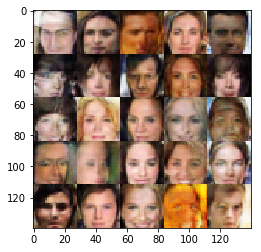

Epoch 1/1 ...  Discriminator loss = 0.383009 Generator loss = 2.383757
Epoch 1/1 ...  Discriminator loss = 0.402396 Generator loss = 2.701316
Epoch 1/1 ...  Discriminator loss = 0.457365 Generator loss = 2.727720
Epoch 1/1 ...  Discriminator loss = 0.464890 Generator loss = 5.068366
Epoch 1/1 ...  Discriminator loss = 0.466078 Generator loss = 2.679325
Epoch 1/1 ...  Discriminator loss = 0.372282 Generator loss = 3.766386
Epoch 1/1 ...  Discriminator loss = 0.383646 Generator loss = 4.038136
Epoch 1/1 ...  Discriminator loss = 0.443782 Generator loss = 2.866727
Epoch 1/1 ...  Discriminator loss = 0.393217 Generator loss = 3.657974
Epoch 1/1 ...  Discriminator loss = 0.376495 Generator loss = 5.092811


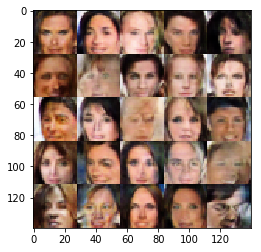

Epoch 1/1 ...  Discriminator loss = 0.388108 Generator loss = 3.986446
Epoch 1/1 ...  Discriminator loss = 0.357707 Generator loss = 4.222636
Epoch 1/1 ...  Discriminator loss = 0.368630 Generator loss = 2.825971
Epoch 1/1 ...  Discriminator loss = 0.401678 Generator loss = 4.055987
Epoch 1/1 ...  Discriminator loss = 0.437736 Generator loss = 3.005189
Epoch 1/1 ...  Discriminator loss = 0.595449 Generator loss = 2.498392
Epoch 1/1 ...  Discriminator loss = 0.356445 Generator loss = 1.901458
Epoch 1/1 ...  Discriminator loss = 0.476661 Generator loss = 3.456651
Epoch 1/1 ...  Discriminator loss = 0.415515 Generator loss = 2.304776
Epoch 1/1 ...  Discriminator loss = 0.403539 Generator loss = 3.366937


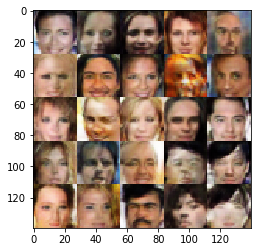

Epoch 1/1 ...  Discriminator loss = 0.408073 Generator loss = 3.848355
Epoch 1/1 ...  Discriminator loss = 0.388491 Generator loss = 4.882938
Epoch 1/1 ...  Discriminator loss = 0.392015 Generator loss = 3.753690
Epoch 1/1 ...  Discriminator loss = 0.760759 Generator loss = 2.687001
Epoch 1/1 ...  Discriminator loss = 0.414218 Generator loss = 3.588184
Epoch 1/1 ...  Discriminator loss = 0.450392 Generator loss = 3.332104
Epoch 1/1 ...  Discriminator loss = 0.422391 Generator loss = 3.677907
Epoch 1/1 ...  Discriminator loss = 0.429655 Generator loss = 3.405502
Epoch 1/1 ...  Discriminator loss = 0.386196 Generator loss = 3.170040
Epoch 1/1 ...  Discriminator loss = 0.551994 Generator loss = 2.978073


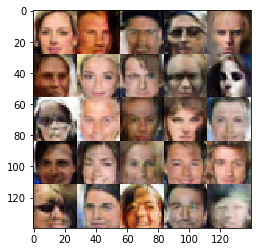

Epoch 1/1 ...  Discriminator loss = 0.373384 Generator loss = 2.953593
Epoch 1/1 ...  Discriminator loss = 0.447573 Generator loss = 2.961995
Epoch 1/1 ...  Discriminator loss = 0.436556 Generator loss = 3.121270
Epoch 1/1 ...  Discriminator loss = 0.373075 Generator loss = 2.909495
Epoch 1/1 ...  Discriminator loss = 0.362928 Generator loss = 3.821205
Epoch 1/1 ...  Discriminator loss = 0.385662 Generator loss = 2.446322
Epoch 1/1 ...  Discriminator loss = 0.565600 Generator loss = 4.230255
Epoch 1/1 ...  Discriminator loss = 0.478821 Generator loss = 2.918416
Epoch 1/1 ...  Discriminator loss = 0.671242 Generator loss = 2.533999
Epoch 1/1 ...  Discriminator loss = 0.391744 Generator loss = 2.411826


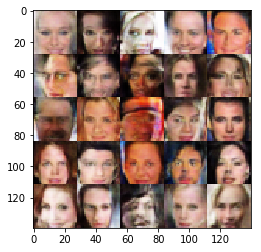

Epoch 1/1 ...  Discriminator loss = 0.444422 Generator loss = 3.155128
Epoch 1/1 ...  Discriminator loss = 0.419130 Generator loss = 2.533270
Epoch 1/1 ...  Discriminator loss = 0.499230 Generator loss = 2.472126
Epoch 1/1 ...  Discriminator loss = 0.370587 Generator loss = 4.094333
Epoch 1/1 ...  Discriminator loss = 0.398374 Generator loss = 3.480690
Epoch 1/1 ...  Discriminator loss = 0.535941 Generator loss = 2.321609
Epoch 1/1 ...  Discriminator loss = 0.400690 Generator loss = 3.229467
Epoch 1/1 ...  Discriminator loss = 0.405068 Generator loss = 3.412498
Epoch 1/1 ...  Discriminator loss = 0.415086 Generator loss = 3.201361
Epoch 1/1 ...  Discriminator loss = 0.377915 Generator loss = 2.976553


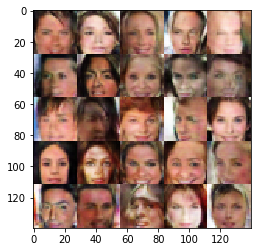

Epoch 1/1 ...  Discriminator loss = 0.393247 Generator loss = 5.289304
Epoch 1/1 ...  Discriminator loss = 0.374682 Generator loss = 4.274515
Epoch 1/1 ...  Discriminator loss = 0.379639 Generator loss = 3.391078
Epoch 1/1 ...  Discriminator loss = 0.375066 Generator loss = 4.652755
Epoch 1/1 ...  Discriminator loss = 0.393554 Generator loss = 4.106235
Epoch 1/1 ...  Discriminator loss = 0.490047 Generator loss = 3.223091
Epoch 1/1 ...  Discriminator loss = 0.492608 Generator loss = 4.180820
Epoch 1/1 ...  Discriminator loss = 0.500504 Generator loss = 3.476639
Epoch 1/1 ...  Discriminator loss = 0.391402 Generator loss = 4.448082
Epoch 1/1 ...  Discriminator loss = 0.378446 Generator loss = 4.162280


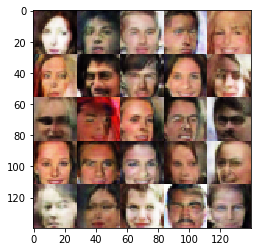

Epoch 1/1 ...  Discriminator loss = 0.355836 Generator loss = 3.851525
Epoch 1/1 ...  Discriminator loss = 0.339827 Generator loss = 4.872159
Epoch 1/1 ...  Discriminator loss = 0.554030 Generator loss = 2.893636
Epoch 1/1 ...  Discriminator loss = 0.546468 Generator loss = 2.683765
Epoch 1/1 ...  Discriminator loss = 0.416919 Generator loss = 3.552975
Epoch 1/1 ...  Discriminator loss = 0.363637 Generator loss = 4.880844
Epoch 1/1 ...  Discriminator loss = 0.419306 Generator loss = 3.716419
Epoch 1/1 ...  Discriminator loss = 0.442553 Generator loss = 2.286278
Epoch 1/1 ...  Discriminator loss = 0.370408 Generator loss = 3.877960
Epoch 1/1 ...  Discriminator loss = 0.374107 Generator loss = 4.219374


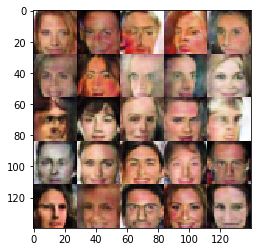

Epoch 1/1 ...  Discriminator loss = 0.499765 Generator loss = 2.739381
Epoch 1/1 ...  Discriminator loss = 0.587282 Generator loss = 3.504347
Epoch 1/1 ...  Discriminator loss = 0.378012 Generator loss = 3.972738
Epoch 1/1 ...  Discriminator loss = 0.418988 Generator loss = 3.617323
Epoch 1/1 ...  Discriminator loss = 0.386751 Generator loss = 3.412096
Epoch 1/1 ...  Discriminator loss = 0.400374 Generator loss = 4.861728
Epoch 1/1 ...  Discriminator loss = 0.393412 Generator loss = 3.586351
Epoch 1/1 ...  Discriminator loss = 0.441494 Generator loss = 3.284566
Epoch 1/1 ...  Discriminator loss = 0.569433 Generator loss = 2.454074
Epoch 1/1 ...  Discriminator loss = 0.563230 Generator loss = 4.630187


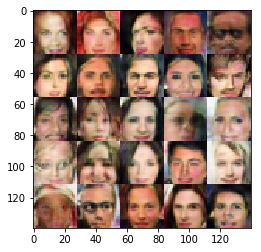

Epoch 1/1 ...  Discriminator loss = 0.451302 Generator loss = 2.719886
Epoch 1/1 ...  Discriminator loss = 0.464900 Generator loss = 2.790961
Epoch 1/1 ...  Discriminator loss = 0.443700 Generator loss = 3.783103
Epoch 1/1 ...  Discriminator loss = 0.400165 Generator loss = 3.469550
Epoch 1/1 ...  Discriminator loss = 0.417668 Generator loss = 2.182630
Epoch 1/1 ...  Discriminator loss = 0.381237 Generator loss = 2.862316
Epoch 1/1 ...  Discriminator loss = 0.362418 Generator loss = 3.948932
Epoch 1/1 ...  Discriminator loss = 0.378253 Generator loss = 4.375069
Epoch 1/1 ...  Discriminator loss = 0.450434 Generator loss = 3.571805
Epoch 1/1 ...  Discriminator loss = 0.566262 Generator loss = 2.650093


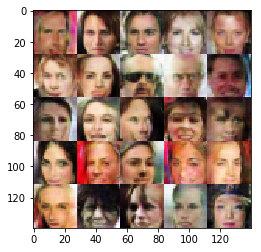

Epoch 1/1 ...  Discriminator loss = 0.379567 Generator loss = 4.134146
Epoch 1/1 ...  Discriminator loss = 0.518157 Generator loss = 2.517646
Epoch 1/1 ...  Discriminator loss = 0.391981 Generator loss = 3.488812
Epoch 1/1 ...  Discriminator loss = 0.389533 Generator loss = 4.908635
Epoch 1/1 ...  Discriminator loss = 0.401534 Generator loss = 4.537824
Epoch 1/1 ...  Discriminator loss = 0.415724 Generator loss = 4.234781
Epoch 1/1 ...  Discriminator loss = 0.372702 Generator loss = 2.303525
Epoch 1/1 ...  Discriminator loss = 0.537956 Generator loss = 2.761989
Epoch 1/1 ...  Discriminator loss = 0.402286 Generator loss = 2.578407
Epoch 1/1 ...  Discriminator loss = 0.741358 Generator loss = 3.402605


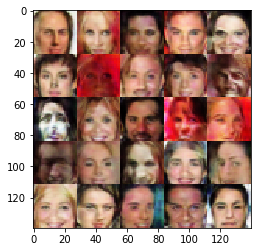

Epoch 1/1 ...  Discriminator loss = 0.404389 Generator loss = 3.310131
Epoch 1/1 ...  Discriminator loss = 0.386942 Generator loss = 3.579209
Epoch 1/1 ...  Discriminator loss = 0.445165 Generator loss = 2.238751
Epoch 1/1 ...  Discriminator loss = 0.344072 Generator loss = 3.980893
Epoch 1/1 ...  Discriminator loss = 0.406844 Generator loss = 4.686866
Epoch 1/1 ...  Discriminator loss = 0.381770 Generator loss = 2.719402
Epoch 1/1 ...  Discriminator loss = 0.416142 Generator loss = 2.137714
Epoch 1/1 ...  Discriminator loss = 0.370250 Generator loss = 3.657318


In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.